In [1]:
# Importing necessary libraries and modules

import numpy as np  # NumPy for numerical operations and handling arrays
import matplotlib.pyplot as plt  # Matplotlib for plotting and visualizations
from keras.models import Sequential  # Sequential model for building neural networks
from keras.layers import Dense  # Dense layer for fully connected neural networks
from keras.optimizers import Adam  # Adam optimizer for training the model
from keras.utils import to_categorical  # Utility for one-hot encoding class labels
from keras.layers import Dropout, Flatten  # Dropout layer for regularization and Flatten layer to convert 2D to 1D
from keras.layers import Conv2D, MaxPooling2D  # Convolutional and pooling layers for CNNs
from keras.models import load_model  # Function to load a pre-trained model from disk
import cv2  # OpenCV for image processing tasks
from sklearn.model_selection import train_test_split  # Utility to split datasets into training and testing sets
import pickle  # Module for serializing and deserializing Python objects (e.g., saving models)
import os  # Module for interacting with the operating system (e.g., file paths)
import pandas as pd  # Pandas for data manipulation and analysis with DataFrames
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Class for real-time data augmentation of images

In [2]:
# Define the path to the dataset and label file
path = "Dataset"  # Directory containing the image classes
labelFile = 'labels.csv'  # CSV file containing labels for the images

# Set parameters for training
batch_size_val = 32  # Number of samples per gradient update
epochs_val = 10  # Number of epochs to train the model
imageDimesions = (32, 32, 3)  # Dimensions of the input images (height, width, channels)
testRatio = 0.2  # Ratio of the dataset to be used for testing
validationRatio = 0.2  # Ratio of the training dataset to be used for validation

# Initialize counters and lists to store images and their corresponding class numbers
count = 0  # Class counter
images = []  # List to store images
classNo = []  # List to store class numbers corresponding to the images

# List all subdirectories (classes) in the dataset directory
myList = os.listdir(path)  # Get a list of all classes (subdirectories) in the dataset
print("Total Classes Detected:", len(myList))  # Print the number of classes detected
noOfClasses = len(myList)  # Store the number of classes

print("Importing Classes.....")  # Indicate the start of class importing
# Loop through each class directory
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))  # List all images in the current class directory
    # Loop through each image in the current class directory
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)  # Read the current image
        images.append(curImg)  # Append the image to the images list
        classNo.append(count)  # Append the class number to the classNo list
    print(count, end=" ")  # Print the current class number
    count += 1  # Increment the class counter

print(" ")  # Print a newline for better readability

# Convert the lists of images and class numbers to NumPy arrays for further processing
images = np.array(images)  # Convert images list to a NumPy array
classNo = np.array(classNo)  # Convert classNo list to a NumPy array

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [3]:
# Split the dataset into training and testing sets
# The test set will be a portion of the images and their corresponding class numbers
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
# Further split the training set into training and validation sets
# The validation set will be a portion of the training data used to tune the model
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# Print the shapes of the resulting datasets for verification
print("Data Shapes")  # Indicate that data shapes will be printed
print("Train", end="")  # Print 'Train' without a newline
print(X_train.shape, y_train.shape)  # Print the shape of training images and labels
print("Validation", end="")  # Print 'Validation' without a newline
print(X_validation.shape, y_validation.shape)  # Print the shape of validation images and labels
print("Test", end="")  # Print 'Test' without a newline
print(X_test.shape, y_test.shape)  # Print the shape of test images and labels

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [4]:
# Load the labels from the CSV file into a DataFrame
data = pd.read_csv(labelFile)  # Read the labels from the specified CSV file
print("data shape ", data.shape, type(data))  # Print the shape and type of the DataFrame

# Initialize a list to store the number of samples for each class
num_of_samples = []  # List to hold the number of samples per class
cols = 5  # Number of columns for displaying images (not used in this snippet)
num_classes = noOfClasses  # Total number of classes detected

# Function to convert an image to grayscale
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert the image from BGR to grayscale
    return img  # Return the grayscale image

# Function to equalize the histogram of an image
def equalize(img):
    img = cv2.equalizeHist(img)  # Apply histogram equalization to improve contrast
    return img  # Return the equalized image

# Function to preprocess an image
def preprocessing(img):
    img = grayscale(img)  # Convert the image to grayscale
    img = equalize(img)  # Equalize the histogram of the grayscale image
    img = img / 255  # Normalize the pixel values to the range [0, 1]
    return img  # Return the preprocessed image

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


In [ ]:
# Apply the preprocessing function to each image in the training, validation, and test sets
# The preprocessing function converts images to grayscale, equalizes them, and normalizes pixel values
X_train = np.array(list(map(preprocessing, X_train)))  # Preprocess all training images
X_validation = np.array(list(map(preprocessing, X_validation)))  # Preprocess all validation images
X_test = np.array(list(map(preprocessing, X_test)))  # Preprocess all test images

# Reshape the training, validation, and test sets to add a channel dimension for compatibility with the model
# The new shape will be (number of samples, height, width, channels)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)  # Reshape training images
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)  # Reshape validation images
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)  # Reshape test images

In [6]:
# Create an instance of the ImageDataGenerator class for data augmentation
dataGen = ImageDataGenerator(
    width_shift_range=0.1,      # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,     # Randomly shift images vertically by 10% of the height
    zoom_range=0.2,             # Randomly zoom in on images by up to 20%
    shear_range=0.1,            # Randomly apply shear transformations by 10%
    rotation_range=10           # Randomly rotate images by up to 10 degrees
)

# Fit the data generator to the training data
dataGen.fit(X_train)  # This computes the necessary statistics (like mean and std) for the training data

# Create batches of augmented data from the training set
batches = dataGen.flow(X_train, y_train, batch_size=20)  # Generate batches of 20 samples

# Get the next batch of images and their corresponding labels
X_batch, y_batch = next(batches)  # Retrieve one batch of augmented data

In [7]:
# Convert the class labels for the training, validation, and test sets to one-hot encoded format
y_train = to_categorical(y_train, noOfClasses)  # Convert training labels to one-hot encoding
y_validation = to_categorical(y_validation, noOfClasses)  # Convert validation labels to one-hot encoding
y_test = to_categorical(y_test, noOfClasses)  # Convert test labels to one-hot encoding

In [ ]:
def myModel():
    # Initialize a sequential model
    model = Sequential()
    # Add the first convolutional layer with 60 filters, each of size 5x5
    # The input shape is defined as (height, width, channels), where channels is 1 for grayscale images
    model.add((Conv2D(60, (5, 5), input_shape=(imageDimesions[0], imageDimesions[1], 1), activation='relu')))
    # Add a second convolutional layer with 60 filters of size 5x5
    model.add((Conv2D(60, (5, 5), activation='relu')))
    # Add a max pooling layer to downsample the feature maps
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a third convolutional layer with 30 filters of size 3x3
    model.add((Conv2D(30, (3, 3), activation='relu')))
    # Add a fourth convolutional layer with 30 filters of size 3x3
    model.add((Conv2D(30, (3, 3), activation='relu')))
    # Add another max pooling layer to further downsample the feature maps
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Add a dropout layer to reduce overfitting by randomly setting 50% of the input units to 0
    model.add(Dropout(0.5))
    # Flatten the output from the previous layer to feed into the dense layer
    model.add(Flatten())
    # Add a fully connected (dense) layer with 500 units and ReLU activation
    model.add(Dense(500, activation='relu'))
    # Add another dropout layer to reduce overfitting
    model.add(Dropout(0.5))
    # Add the output layer with a number of units equal to the number of classes and softmax activation
    model.add(Dense(noOfClasses, activation='softmax'))
    # Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy as a metric
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    # Return the constructed model
    return model

In [ ]:
# Create an instance of the model defined in the myModel function
model = myModel()
# Print the summary of the model architecture, including layer types, output shapes, and number of parameters
print(model.summary())
# Train the model using the fit method
# The training data is generated using the data generator with data augmentation
history = model.fit(
    dataGen.flow(X_train, y_train, batch_size=32),  # Generate batches of augmented training data
    steps_per_epoch=len(X_train) // 32,  # Number of steps to complete one epoch
    epochs=epochs_val,  # Number of epochs to train the model
    validation_data=(X_validation, y_validation),  # Validation data to evaluate the model during training
    shuffle=1  # Shuffle the training data before each epoch
)

c:\Users\BABAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


c:\Users\BABAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


695/695 ━━━━━━━━━━━━━━━━━━━━ 114s 154ms/step - accuracy: 0.1723 - loss: 3.0578 - val_accuracy: 0.7656 - val_loss: 0.7548
Epoch 2/10
  1/695 ━━━━━━━━━━━━━━━━━━━━ 1:41 147ms/step - accuracy: 0.5938 - loss: 1.7286

c:\Users\BABAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


695/695 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5938 - loss: 1.7286 - val_accuracy: 0.7696 - val_loss: 0.7635
Epoch 3/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 103s 148ms/step - accuracy: 0.6018 - loss: 1.2902 - val_accuracy: 0.9318 - val_loss: 0.2929
Epoch 4/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6875 - loss: 1.1744 - val_accuracy: 0.9307 - val_loss: 0.3226
Epoch 5/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 114s 163ms/step - accuracy: 0.7474 - loss: 0.8171 - val_accuracy: 0.9574 - val_loss: 0.1636
Epoch 6/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8438 - loss: 0.6667 - val_accuracy: 0.9578 - val_loss: 0.1575
Epoch 7/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 99s 143ms/step - accuracy: 0.8059 - loss: 0.6343 - val_accuracy: 0.9567 - val_loss: 0.1444
Epoch 8/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7500 - loss: 0.7462 - val_accuracy: 0.9626 - val_loss: 0.1356
Epoch 9/10
695/695 ━━━━━━━━━━━━━━━━━━━━ 91s 130ms/step - accuracy: 0.8399 - loss: 0.5115 - val_accuracy:

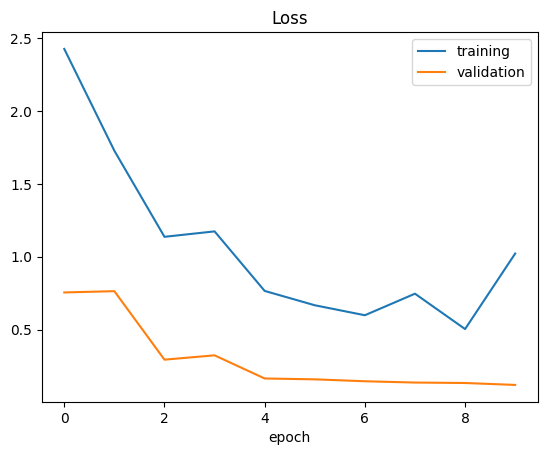

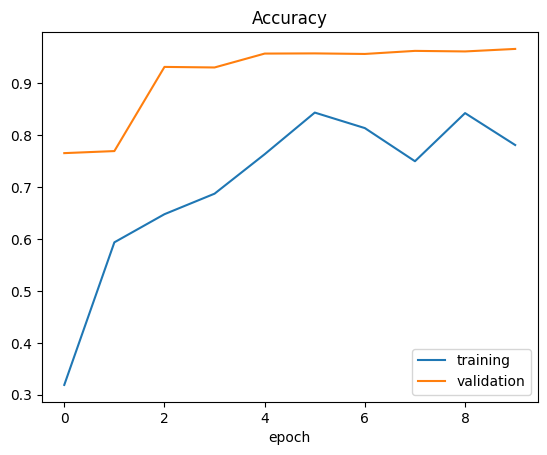

In [ ]:
# Create a new figure for plotting the loss
plt.figure(1)
# Plot the training loss over epochs
plt.plot(history.history['loss'])
# Plot the validation loss over epochs
plt.plot(history.history['val_loss'])
# Add a legend to differentiate between training and validation loss
plt.legend(['training', 'validation'])
# Set the title of the plot
plt.title('Loss')
# Label the x-axis as 'epoch'
plt.xlabel('epoch')
# Create a new figure for plotting the accuracy
plt.figure(2)
# Plot the training accuracy over epochs
plt.plot(history.history['accuracy'])
# Plot the validation accuracy over epochs
plt.plot(history.history['val_accuracy'])
# Add a legend to differentiate between training and validation accuracy
plt.legend(['training', 'validation'])
# Set the title of the plot
plt.title('Accuracy')
# Label the x-axis as 'epoch'
plt.xlabel('epoch')
# Display the plots
plt.show()

In [ ]:
# Evaluate the model on the test dataset
# The evaluate method returns the loss value and metrics specified during model compilation
score = model.evaluate(X_test, y_test, verbose=0)
# Print the test score (loss) from the evaluation
print('Test Score:', score[0])
# Print the test accuracy from the evaluation
print('Test Accuracy:', score[1])

Test Score: 0.12101157754659653
Test Accuracy: 0.9643678069114685


In [ ]:
# Save the model
model.save('model.keras') 
model.save('model.h5')
# Load the model
loaded_model = load_model('model.h5')

In [ ]:
def predict_image(image_path,model,image_dimensions=(32, 32)):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path '{image_path}' not found.")
    # Preprocess the image
    img = cv2.resize(img, (image_dimensions[0], image_dimensions[1]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.equalizeHist(img)  # Equalize
    img = img / 255.0           # Normalize pixel values
    img = img.reshape(1, image_dimensions[0], image_dimensions[1], 1)  # Add batch dimension
    # Predict using the model
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)  # Get the class with the highest probability
    df =pd.read_csv('labels.csv')
    Sign = df.iloc[predicted_class,1]
    result = f"The Traffic-Sign in the Image States That: \n{Sign}"
    print (result)


In [ ]:
#Predicting a new image
path = "C:/Users/BABAR/Desktop/Traffic Signs Recognition/images.png"
predict_image(path,loaded_model)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
The Traffic-Sign in the Image States That: 
Stop
